# Перший експеремент

Бінарна класифікація із кільцями

In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

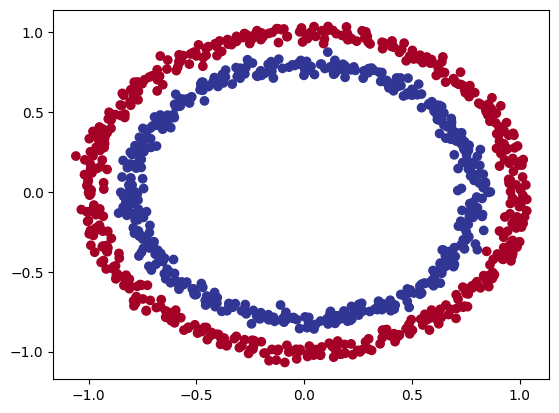

In [2]:
n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)

In [3]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=4)
        self.layer_2 = nn.Linear(in_features=4, out_features=1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        return self.layer_2(self.softplus(self.layer_1(x)))

circle_model = CircleModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=circle_model.parameters(), lr=0.1)

def accuracy_fun(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Epoch: 10 | Loss: 0.72419, Accuracy: 50.00% | Test loss: 0.72514, Test acc: 50.00%
Epoch: 20 | Loss: 0.70009, Accuracy: 50.00% | Test loss: 0.70215, Test acc: 50.00%
Epoch: 30 | Loss: 0.69454, Accuracy: 50.00% | Test loss: 0.69645, Test acc: 50.00%
Epoch: 40 | Loss: 0.69327, Accuracy: 57.38% | Test loss: 0.69493, Test acc: 52.00%
Epoch: 50 | Loss: 0.69297, Accuracy: 52.38% | Test loss: 0.69447, Test acc: 46.50%
Epoch: 60 | Loss: 0.69289, Accuracy: 52.38% | Test loss: 0.69429, Test acc: 45.50%
Epoch: 70 | Loss: 0.69286, Accuracy: 51.38% | Test loss: 0.69420, Test acc: 47.00%
Epoch: 80 | Loss: 0.69284, Accuracy: 51.62% | Test loss: 0.69413, Test acc: 46.50%
Epoch: 90 | Loss: 0.69283, Accuracy: 51.00% | Test loss: 0.69409, Test acc: 47.00%
Epoch: 100 | Loss: 0.69281, Accuracy: 50.88% | Test loss: 0.69404, Test acc: 46.50%
Epoch: 110 | Loss: 0.69280, Accuracy: 51.00% | Test loss: 0.69400, Test acc: 46.50%
Epoch: 120 | Loss: 0.69279, Accuracy: 51.00% | Test loss: 0.69396, Test acc: 46.00%
E

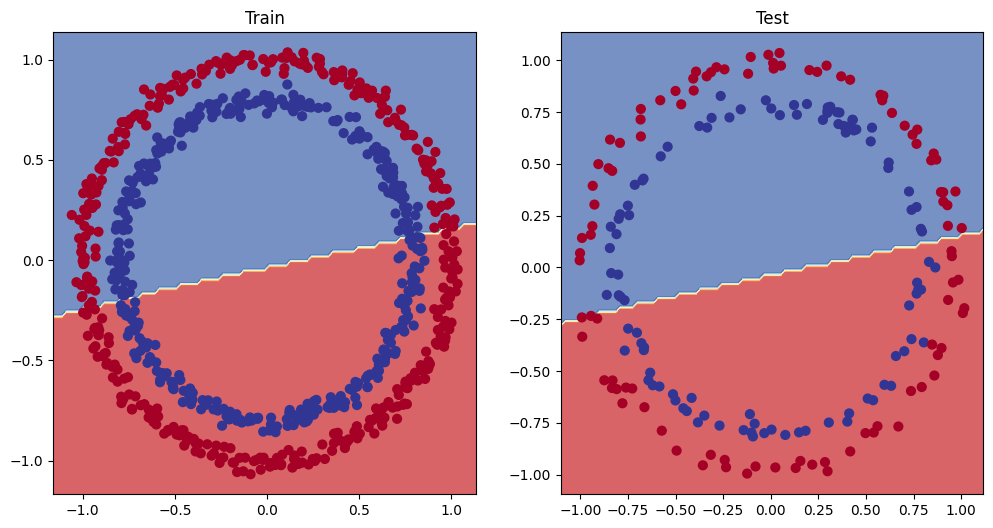

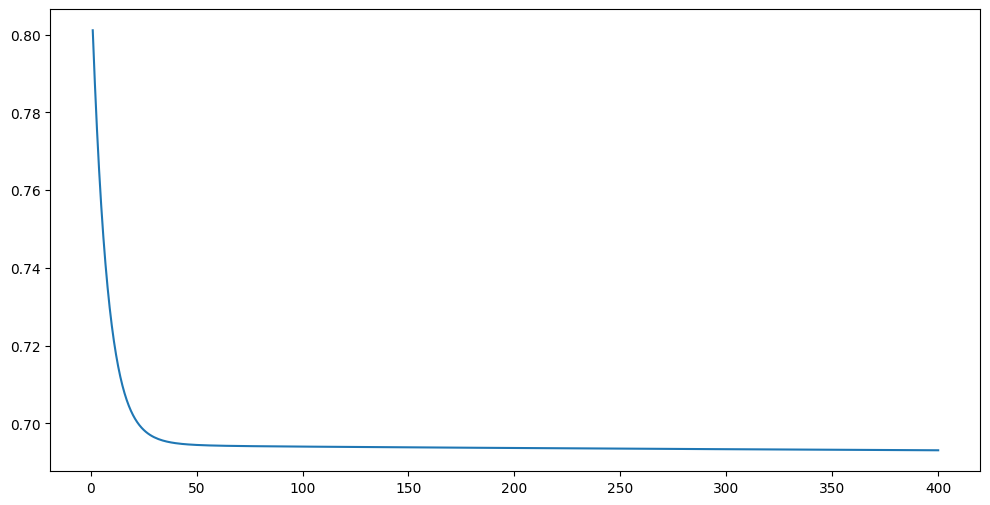

In [5]:
torch.manual_seed(23)

epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    circle_model.train()

    y_logits = circle_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    circle_model.eval()
    with torch.inference_mode():

        test_logits = circle_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model, X_test, y_test)
plt.savefig("first.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs + 1)], loss_list)
plt.savefig("first_loss.png")

# Результат першого тесту

Обравши параметри моделі, які були оптимальні для мультикласової класифікації, бінарна модель не змогла навчитись. 

**Переходимо до другого експеременту**

Змінюємо Softplus на GELU 

Epoch: 10 | Loss: 0.69693, Accuracy: 50.00% | Test loss: 0.69456, Test acc: 50.00%
Epoch: 20 | Loss: 0.69500, Accuracy: 50.00% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 30 | Loss: 0.69382, Accuracy: 50.00% | Test loss: 0.69155, Test acc: 50.00%
Epoch: 40 | Loss: 0.69306, Accuracy: 50.00% | Test loss: 0.69082, Test acc: 50.00%
Epoch: 50 | Loss: 0.69254, Accuracy: 44.00% | Test loss: 0.69034, Test acc: 45.50%
Epoch: 60 | Loss: 0.69216, Accuracy: 47.62% | Test loss: 0.68999, Test acc: 50.00%
Epoch: 70 | Loss: 0.69186, Accuracy: 48.62% | Test loss: 0.68972, Test acc: 53.00%
Epoch: 80 | Loss: 0.69161, Accuracy: 49.12% | Test loss: 0.68950, Test acc: 54.50%
Epoch: 90 | Loss: 0.69138, Accuracy: 49.50% | Test loss: 0.68931, Test acc: 55.00%
Epoch: 100 | Loss: 0.69117, Accuracy: 49.88% | Test loss: 0.68913, Test acc: 55.00%
Epoch: 110 | Loss: 0.69097, Accuracy: 50.12% | Test loss: 0.68896, Test acc: 56.50%
Epoch: 120 | Loss: 0.69078, Accuracy: 50.75% | Test loss: 0.68880, Test acc: 56.00%
E

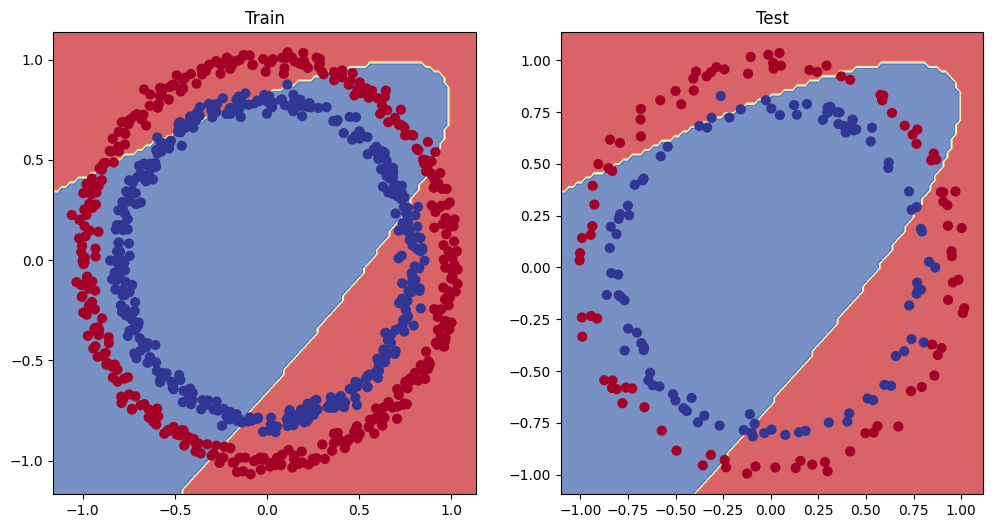

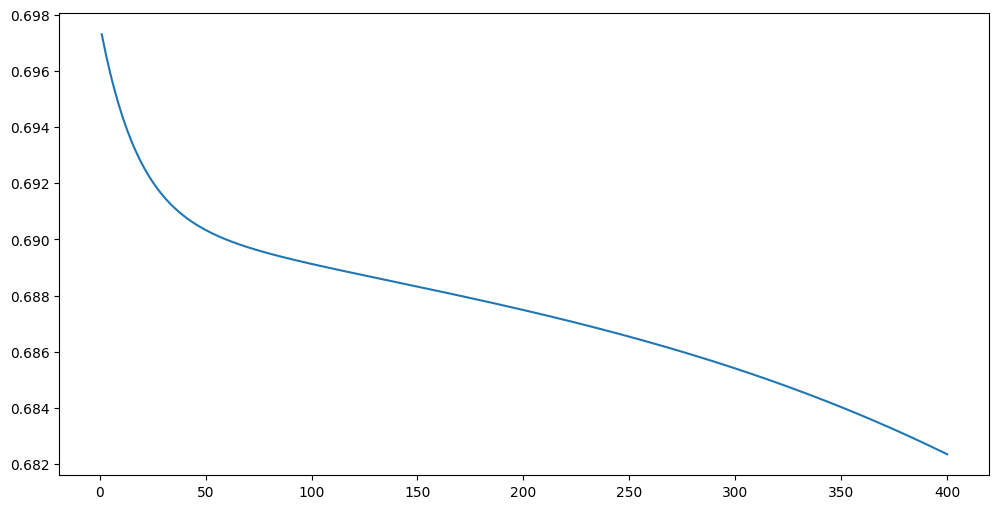

In [6]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=4)
        self.layer_2 = nn.Linear(in_features=4, out_features=1)
        self.gelu = nn.GELU()

    def forward(self, x):
        return self.layer_2(self.gelu(self.layer_1(x)))

circle_model = CircleModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=circle_model.parameters(), lr=0.1)

torch.manual_seed(23)

epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    circle_model.train()

    y_logits = circle_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    circle_model.eval()
    with torch.inference_mode():

        test_logits = circle_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model, X_test, y_test)
plt.savefig("second.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs+1)], loss_list)
plt.savefig("second_loss.png")

# Результат другого експеременту

Бачимо покращення в роботі моделі, але все ще недостатні.

**Третій експеремент**

Повертаємось до ReLU, та експерементуємо з товщиною слоїв, learning rate та епохами

Epoch: 10 | Loss: 0.68167, Accuracy: 60.00% | Test loss: 0.68512, Test acc: 49.00%
Epoch: 20 | Loss: 0.66738, Accuracy: 72.88% | Test loss: 0.67431, Test acc: 50.00%
Epoch: 30 | Loss: 0.70723, Accuracy: 50.00% | Test loss: 0.68410, Test acc: 50.50%
Epoch: 40 | Loss: 0.63516, Accuracy: 68.75% | Test loss: 0.65298, Test acc: 59.00%
Epoch: 50 | Loss: 0.64025, Accuracy: 73.75% | Test loss: 0.65320, Test acc: 55.50%
Epoch: 60 | Loss: 0.58409, Accuracy: 87.38% | Test loss: 0.60899, Test acc: 69.00%
Epoch: 70 | Loss: 0.56880, Accuracy: 87.75% | Test loss: 0.59194, Test acc: 79.50%
Epoch: 80 | Loss: 0.52450, Accuracy: 80.50% | Test loss: 0.60579, Test acc: 52.00%
Epoch: 90 | Loss: 0.70754, Accuracy: 50.00% | Test loss: 0.65865, Test acc: 50.00%
Epoch: 100 | Loss: 0.63321, Accuracy: 51.12% | Test loss: 0.62334, Test acc: 51.00%
Epoch: 110 | Loss: 0.63118, Accuracy: 52.38% | Test loss: 0.61630, Test acc: 53.00%
Epoch: 120 | Loss: 0.61503, Accuracy: 55.00% | Test loss: 0.60556, Test acc: 55.00%
E

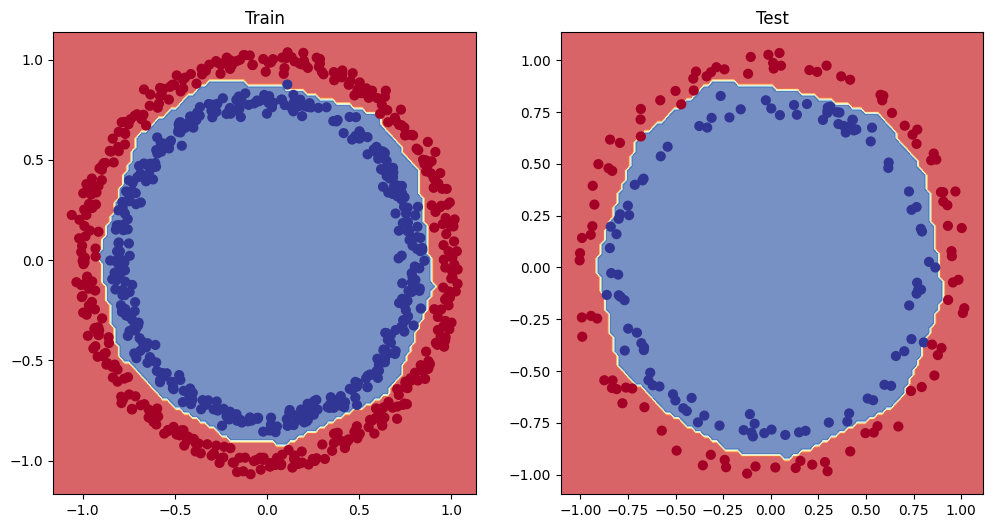

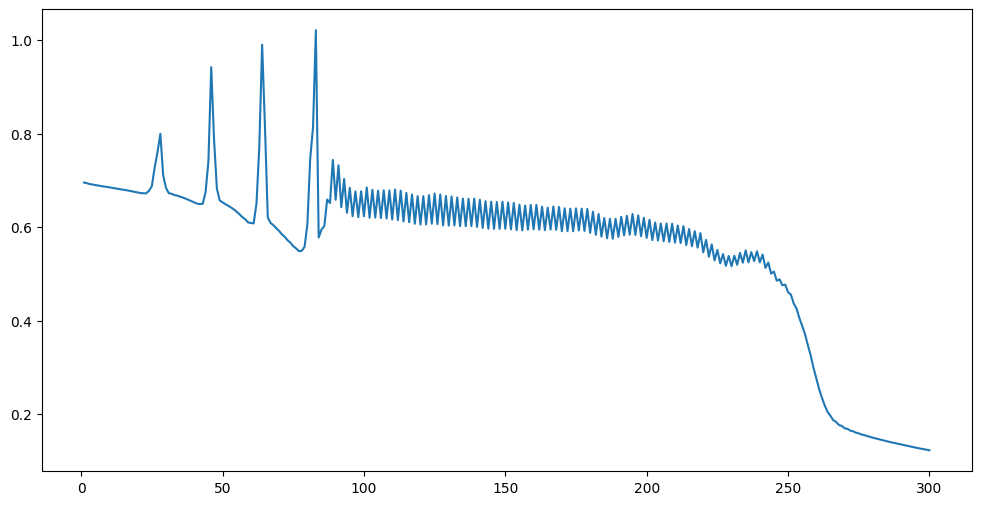

In [7]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=11)
        self.layer_2 = nn.Linear(in_features=11, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))

circle_model = CircleModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=circle_model.parameters(), lr=3)

torch.manual_seed(23)

epochs = 300

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    circle_model.train()

    y_logits = circle_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    circle_model.eval()
    with torch.inference_mode():

        test_logits = circle_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model, X_test, y_test)
plt.savefig("third.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs+1)], loss_list)
plt.savefig("third_loss.png")

## Висновки

На основі останнього експеременту, можеможе підбити підсумки:

- Для бінарної класифікації Relu підходить краще за інші функції активації
- Для даного датасету learning rate 3 є найоптимальнішим
- Два слої, де другий має 11 нейронів - оптимальні показники
- На 290 епосі досягається результат в 100%